In [62]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/Colab Notebooks/cs231n/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

#this allows the colab VM to load the python files within it
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1/cs231n/datasets
/content/drive/My Drive/Colab Notebooks/cs231n/assignment1


We can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image.
In this notebook, I'll show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.



In [63]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [64]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_cifar10_data(num_training=49000, num_test=1000, num_valid=1000):
  try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
  except:
    pass
  X_train, y_train, X_test, y_test = load_CIFAR10('cs231n/datasets/cifar-10-batches-py')

  mask = list(range(num_training, num_training + num_valid))
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = list(range(num_training))
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = list(range(num_test))
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_cifar10_data()

# Extracting Features

For each image, I am computing a Histogram of Oriented Gradients (HOG) as well as a color histogram using the hue channel in HSV color space. The final feature vector for each image is formed by concatenating the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring color information, and the color histogram represents the color of the input image while ignoring texture. As a result, it is expected that using both together ought to work better than using either alone.

The hog_feature and color_histogram_hsv functions both operate on a single image and return a feature vector for that image. The extract_features function takes a set of images and a list of feature functions and evaluates each feature function on each image, storing the results in a matrix where each column is the concatenation of all feature vectors for a single image.

In [65]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [66]:
from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=False)

        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.084857 val accuracy: 0.083000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.092755 val accuracy: 0.095000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.416204 val accuracy: 0.422000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.105143 val accuracy: 0.094000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.417347 val accuracy: 0.418000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.411286 val accuracy: 0.424000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.422000 val accuracy: 0.425000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.407653 val accuracy: 0.394000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.333082 val accuracy: 0.324000
best validation accuracy achieved during cross-validation: 0.425000


The difference in speed/accuracy is notably different, and features work better both ways.

In [67]:
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.432


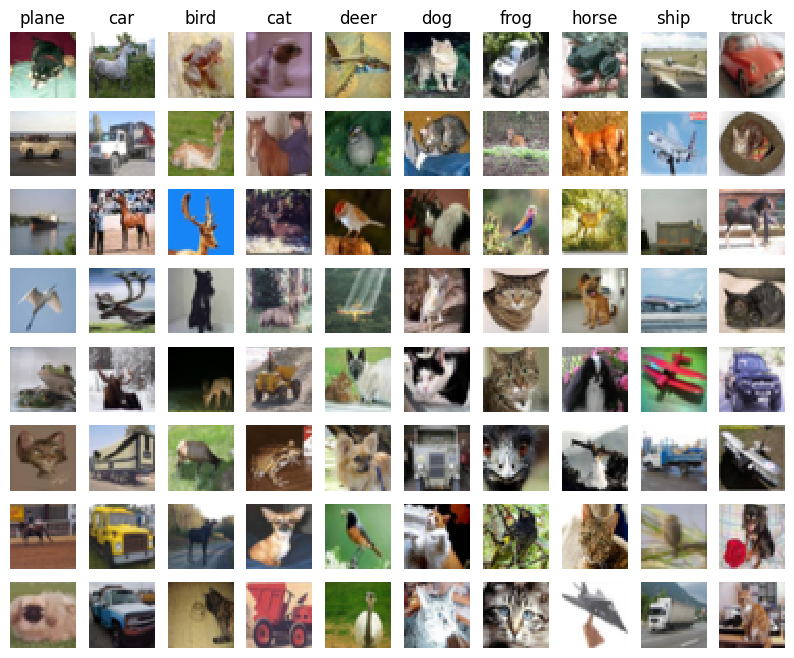

In [68]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

## Neural Network on image features
In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [69]:
#Preprocessing; remove the bias term
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [70]:
import numpy as np

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def loss(self, X, y=None, reg=0.0):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Forward pass
        hidden = self.relu(X.dot(W1) + b1)
        scores = hidden.dot(W2) + b2

        if y is None:
            return scores

        # Compute softmax loss
        probs = self.softmax(scores)
        N = X.shape[0]
        loss = -np.sum(np.log(probs[np.arange(N), y])) / N
        loss += reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))

        # Backward pass
        grads = {}
        dscores = probs
        dscores[np.arange(N), y] -= 1
        dscores /= N

        grads['W2'] = hidden.T.dot(dscores) + 2 * reg * W2
        grads['b2'] = np.sum(dscores, axis=0)

        dhidden = dscores.dot(W2.T)
        dhidden[hidden <= 0] = 0  # ReLU backward

        grads['W1'] = X.T.dot(dhidden) + 2 * reg * W1
        grads['b1'] = np.sum(dhidden, axis=0)

        return loss, grads

    def predict(self, X):
        hidden = self.relu(X.dot(self.params['W1']) + self.params['b1'])
        scores = hidden.dot(self.params['W2']) + self.params['b2']
        return np.argmax(scores, axis=1)

In [71]:
class SimpleSolver:
    def __init__(self, model, data, learning_rate=1e-3, reg=0.0, num_epochs=10,
                 batch_size=200, verbose=True):
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']
        self.learning_rate = learning_rate
        self.reg = reg
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def train(self):
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)

        for epoch in range(self.num_epochs):
            for i in range(iterations_per_epoch):
                batch_indices = np.random.choice(num_train, self.batch_size)
                X_batch = self.X_train[batch_indices]
                y_batch = self.y_train[batch_indices]

                loss, grads = self.model.loss(X_batch, y_batch, self.reg)

                for param in self.model.params:
                    self.model.params[param] -= self.learning_rate * grads[param]

            if self.verbose:
                train_acc = (self.model.predict(self.X_train) == self.y_train).mean()
                val_acc = (self.model.predict(self.X_val) == self.y_val).mean()
                print(f"Epoch {epoch + 1}: Loss {loss:.4f} | Train Acc: {train_acc * 100:.2f}% | Val Acc: {val_acc * 100:.2f}%")

In [72]:
input_dim = X_train_feats.shape[1]
num_classes = 10

# Normalize features
mean_feat = np.mean(X_train_feats, axis=0)
std_feat = np.std(X_train_feats, axis=0) + 1e-8

X_train_feats = (X_train_feats - mean_feat) / std_feat
X_val_feats = (X_val_feats - mean_feat) / std_feat
X_test_feats = (X_test_feats - mean_feat) / std_feat

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

results = {}
best_val_acc = 0.0
best_net = None

learning_rates = [1e-3, 5e-3, 1e-2]
regularization_strengths = [0.0, 1e-5, 1e-4]
hidden_dims = [300, 500, 700]

for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_dim in hidden_dims:
            print(f"Training model with lr={lr}, reg={reg}, hidden_dim={hidden_dim}")
            net = TwoLayerNet(input_dim, hidden_dim, num_classes)

            solver = SimpleSolver(net, {
                'X_train': X_train_feats,
                'y_train': y_train,
                'X_val': X_val_feats,
                'y_val': y_val
            }, learning_rate=lr, reg=reg, num_epochs=20, batch_size=200, verbose=False)

            solver.train()

            train_acc = (net.predict(X_train_feats) == y_train).mean()
            val_acc = (net.predict(X_val_feats) == y_val).mean()

            results[(lr, reg, hidden_dim)] = (train_acc, val_acc)
            print(f"Train acc: {train_acc*100:.2f}%, Val acc: {val_acc*100:.2f}%")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net

print(f"\nBest validation accuracy: {best_val_acc * 100:.2f}%")

# Test accuracy
y_test_pred = best_net.predict(X_test_feats)
test_acc = np.mean(y_test_pred == y_test)
print(f"Final test accuracy of best model: {test_acc * 100:.2f}%")

Training model with lr=0.001, reg=0.0, hidden_dim=300
Train acc: 35.25%, Val acc: 35.00%
Training model with lr=0.001, reg=0.0, hidden_dim=500
Train acc: 37.24%, Val acc: 39.40%
Training model with lr=0.001, reg=0.0, hidden_dim=700
Train acc: 38.20%, Val acc: 40.70%
Training model with lr=0.001, reg=1e-05, hidden_dim=300
Train acc: 36.40%, Val acc: 36.10%
Training model with lr=0.001, reg=1e-05, hidden_dim=500
Train acc: 37.10%, Val acc: 38.70%
Training model with lr=0.001, reg=1e-05, hidden_dim=700
Train acc: 37.64%, Val acc: 37.80%
Training model with lr=0.001, reg=0.0001, hidden_dim=300
Train acc: 35.96%, Val acc: 36.40%
Training model with lr=0.001, reg=0.0001, hidden_dim=500
Train acc: 38.16%, Val acc: 39.30%
Training model with lr=0.001, reg=0.0001, hidden_dim=700
Train acc: 37.48%, Val acc: 38.10%
Training model with lr=0.005, reg=0.0, hidden_dim=300
Train acc: 48.78%, Val acc: 48.20%
Training model with lr=0.005, reg=0.0, hidden_dim=500
Train acc: 49.70%, Val acc: 49.60%
Traini